## Top 500

[https://top500.org/](https://top500.org/)

#### Librerias

In [23]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


import os
import xlrd

import numpy as np
import json

# Habilitar Plots inline
%matplotlib inline

In [4]:
import urllib
import urllib.request

#### Descargar documentos en Excel

In [5]:
descargar = False

In [14]:
if(descargar):
    for year in range(1995, 2019+1):
        print("https://www.top500.org/lists/"+str(year)+"/06/download/TOP500_"+str(year)+"06.xls")    
        urllib.request.urlretrieve("https://www.top500.org/lists/"+str(year)+"/06/download/TOP500_"+str(year)+"06.xls",
                                   "./xls/TOP500_"+str(year)+"06.xls")
        print("https://www.top500.org/lists/"+str(year)+"/11/download/TOP500_"+str(year)+"11.xls")
        urllib.request.urlretrieve("https://www.top500.org/lists/"+str(year)+"/11/download/TOP500_"+str(year)+"11.xls",
                               "./xls/TOP500_"+str(year)+"11.xls")

https://www.top500.org/lists/1995/06/download/TOP500_199506.xls
https://www.top500.org/lists/1995/11/download/TOP500_199511.xls
https://www.top500.org/lists/1996/06/download/TOP500_199606.xls
https://www.top500.org/lists/1996/11/download/TOP500_199611.xls
https://www.top500.org/lists/1997/06/download/TOP500_199706.xls
https://www.top500.org/lists/1997/11/download/TOP500_199711.xls
https://www.top500.org/lists/1998/06/download/TOP500_199806.xls
https://www.top500.org/lists/1998/11/download/TOP500_199811.xls
https://www.top500.org/lists/1999/06/download/TOP500_199906.xls
https://www.top500.org/lists/1999/11/download/TOP500_199911.xls
https://www.top500.org/lists/2000/06/download/TOP500_200006.xls
https://www.top500.org/lists/2000/11/download/TOP500_200011.xls
https://www.top500.org/lists/2001/06/download/TOP500_200106.xls
https://www.top500.org/lists/2001/11/download/TOP500_200111.xls
https://www.top500.org/lists/2002/06/download/TOP500_200206.xls
https://www.top500.org/lists/2002/11/dow

#### Estandarización y Homogenización de datos

In [186]:
col_1995_2011 = "A,B,C,E,F,H"
col_2011 = "A,B,E,F,G,K"
col_2012_2019 = "A,G,H,I,J,N"
columnas = ["ranking", "site", "manufacturer", "country", "year", "rmax"]

In [187]:
# Cargar el dataset desde un archivo de Excel
def getDataset(year:int, month:int, cols:str):
    
    wb = xlrd.open_workbook('./xls/TOP500_'+str(year)+( str(month) if month > 9 else '0'+str(month)) +'.xls', logfile=open(os.devnull, 'w'))
    
    ds = pd.read_excel(wb,
                            engine='xlrd',
                            usecols = cols,
                            names=columnas,
                            #dtype=str,
                            na_values=['NA']
                           )
    ds['rank_month'] = int(month);
    ds['rank_year'] = int(year);
    return ds;
    

In [188]:
array_ds = []


for year in range(1995, 2010+1, 1):
    print(str(year), end = ' ')
    
    array_ds.append(getDataset(year, 6, col_1995_2011))
    array_ds.append(getDataset(year, 11, col_1995_2011))
    
print(str(2011), end = ' ')
# 2011
array_ds.append(getDataset(2011, 6, col_1995_2011))
array_ds.append(getDataset(2011, 11, col_2011))
    
for year in range(2012, 2019+1, 1):
    print(str(year), end = ' ')
    
    array_ds.append(getDataset(year, 6, col_2012_2019))
    array_ds.append(getDataset(year, 11, col_2012_2019))

dataset = pd.concat(array_ds)

1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 

In [190]:
dataset = dataset.reset_index(drop=True)

In [203]:
dataset = dataset.replace(np.nan, '', regex=True)

### Configuración de BD

In [5]:
import psycopg2

In [177]:
param_dic = {
    "host"      : "localhost",
    "database"  : "top500",
    "user"      : "postgres",
    "password"  : "c4224a"
}

In [178]:
def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
        print('Connected')
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    return conn


In [179]:
def single_insert(conn, insert_req):
    """ Execute a single INSERT request """
    cursor = conn.cursor()
    try:
        cursor.execute(insert_req)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1


### Insertar todos los registros en la Base de Datos

In [205]:
conn = connect(param_dic)

for i in dataset.index:
    if(i>=16500):
        query = """
        INSERT INTO public.rankings(ranking, site, manufacturer, country, year, rmax, rank_month, rank_year)
        values(%s,'%s','%s', '%s', %s , %s ,%s,%s);
        """ % (dataset.values[i][0], dataset.values[i][1].replace("'", "´"), dataset.values[i][2], dataset.values[i][3],
               dataset.values[i][4], dataset.values[i][5], dataset.values[i][6], dataset.values[i][7])

        single_insert(conn, query)
        if(int(i) > 0 and i % 1000 == 0):
            print(str(i), end = ' ')
conn.close()

Connecting to the PostgreSQL database...
Connected
17000 18000 19000 20000 21000 22000 23000 24000 

### Recuperar  los datos de la Base de Datos

In [45]:
from sqlalchemy import create_engine
# Postgres username, password, and database name
POSTGRES_DBNAME = 'top500'
POSTGRES_ADDRESS = 'localhost' ## INSERT YOUR DB ADDRESS IF IT'S NOT ON PANOPLY
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'postgres' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES USERNAME
POSTGRES_PASSWORD = 'XXXXX' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES PASSWORD POSTGRES_DBNAME = 'database' ## CHANGE THIS TO YOUR DATABASE NAME
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=POSTGRES_USERNAME,
                        password=POSTGRES_PASSWORD,
                        ipaddress=POSTGRES_ADDRESS,
                        port=POSTGRES_PORT,
                        dbname=POSTGRES_DBNAME))
# Create the connection
cnx = create_engine(postgres_str)

In [46]:
ds_query = pd.read_sql_query('''
SELECT co.country,
       co.rank_year::text AS year,
       co.count::int AS total
FROM
  (SELECT countries.country,
          years.rank_year,
          count(top.*)
   FROM
     (SELECT DISTINCT rank_year
      FROM rankings) years
   CROSS JOIN
     (SELECT DISTINCT country
      FROM rankings) countries
   LEFT JOIN rankings top ON countries.country = top.country
   AND years.rank_year = top.rank_year 

   GROUP BY countries.country,
            years.rank_year
   ORDER BY countries.country,
            years.rank_year ASC)co
''', cnx)

In [47]:
ds_query = ds_query.set_index('year')

In [48]:
ds_query.head(5)

,country,total
year,,
1995,Australia,4
1996,Australia,13
1997,Australia,3
1998,Australia,6
1999,Australia,8


In [53]:
ds_cc = ds_query

In [54]:
ds_cc = ds_cc.sort_index()

In [55]:
ds_cc = ds_cc.pivot(columns='country', values='total')

In [108]:
ds_cc

country,Australia,Austria,Belarus,Belgium,Brazil,Bulgaria,Canada,China,Colombia,Croatia,...,Sweden,Switzerland,Taiwan,Thailand,Turkey,United Arab Emirates,United Kingdom,United States,Venezuela,Vietnam
year,,,,,,,,,,,,,,,,,,,,,
1995,4,4,0,4,2,0,17,2,0,0,...,8,21,4,0,0,0,33,535,0,0
1996,13,5,0,0,0,0,10,2,0,0,...,9,17,3,0,0,0,30,524,0,0
1997,3,0,0,0,3,0,10,0,0,0,...,15,12,2,0,0,0,48,530,0,0
1998,6,0,0,2,2,0,10,0,0,0,...,12,11,2,0,0,0,53,575,0,0
1999,8,3,0,4,0,0,13,1,0,0,...,14,11,1,0,0,0,53,561,0,0
2000,8,5,0,2,3,0,17,2,0,0,...,13,16,4,0,0,0,62,493,0,0
2001,9,5,0,3,3,0,20,3,0,0,...,9,8,8,0,0,0,66,483,3,0
2002,6,2,0,7,5,0,18,8,0,0,...,10,2,6,3,0,0,76,454,1,0
2003,11,3,1,4,5,0,16,16,0,0,...,9,6,7,1,0,0,69,493,0,0


In [122]:
country = 'China'
country2 = 'United States'
ds_cc[country]

year
1995      2
1996      2
1997      0
1998      0
1999      1
2000      2
2001      3
2002      8
2003     16
2004     31
2005     36
2006     46
2007     23
2008     27
2009     42
2010     65
2011    135
2012    140
2013    129
2014    137
2015    146
2016    339
2017    362
2018    433
2019    448
Name: China, dtype: int64

### Graficar Totales

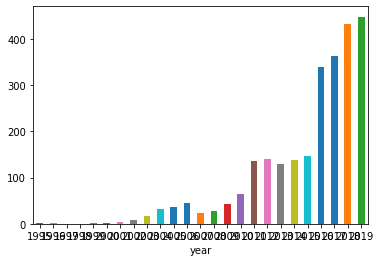

In [124]:
ax = ds_cc[country].plot.bar(rot=0)

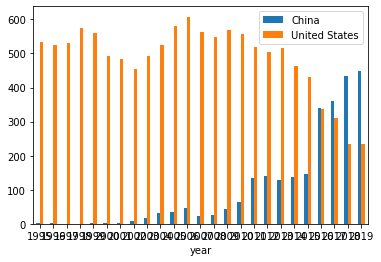

In [125]:
c1 = ds_cc[country].values
c2 = ds_cc[country2].values
index = ds_cc[country].index
df = pd.DataFrame({country: c1,
                   country2: c2}, index=index)
ax = df.plot.bar(rot=0)

In [110]:
d2 = ds_cc.pct_change(axis='rows').replace([np.nan], 0).replace([np.inf, -np.inf], 1)
d2

country,Australia,Austria,Belarus,Belgium,Brazil,Bulgaria,Canada,China,Colombia,Croatia,...,Sweden,Switzerland,Taiwan,Thailand,Turkey,United Arab Emirates,United Kingdom,United States,Venezuela,Vietnam
year,,,,,,,,,,,,,,,,,,,,,
1995,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
1996,2.250000,0.250000,0.0,-1.000000,-1.000000,0.0,-0.411765,0.000000,0.0,0.0,...,0.125000,-0.190476,-0.250000,0.000000,0.0,0.0,-0.090909,-0.020561,0.000000,0.0
1997,-0.769231,-1.000000,0.0,0.000000,1.000000,0.0,0.000000,-1.000000,0.0,0.0,...,0.666667,-0.294118,-0.333333,0.000000,0.0,0.0,0.600000,0.011450,0.000000,0.0
1998,1.000000,0.000000,0.0,1.000000,-0.333333,0.0,0.000000,0.000000,0.0,0.0,...,-0.200000,-0.083333,0.000000,0.000000,0.0,0.0,0.104167,0.084906,0.000000,0.0
1999,0.333333,1.000000,0.0,1.000000,-1.000000,0.0,0.300000,1.000000,0.0,0.0,...,0.166667,0.000000,-0.500000,0.000000,0.0,0.0,0.000000,-0.024348,0.000000,0.0
2000,0.000000,0.666667,0.0,-0.500000,1.000000,0.0,0.307692,1.000000,0.0,0.0,...,-0.071429,0.454545,3.000000,0.000000,0.0,0.0,0.169811,-0.121212,0.000000,0.0
2001,0.125000,0.000000,0.0,0.500000,0.000000,0.0,0.176471,0.500000,0.0,0.0,...,-0.307692,-0.500000,1.000000,0.000000,0.0,0.0,0.064516,-0.020284,1.000000,0.0
2002,-0.333333,-0.600000,0.0,1.333333,0.666667,0.0,-0.100000,1.666667,0.0,0.0,...,0.111111,-0.750000,-0.250000,1.000000,0.0,0.0,0.151515,-0.060041,-0.666667,0.0
2003,0.833333,0.500000,1.0,-0.428571,0.000000,0.0,-0.111111,1.000000,0.0,0.0,...,-0.100000,2.000000,0.166667,-0.666667,0.0,0.0,-0.092105,0.085903,-1.000000,0.0


In [107]:
country = 'China'
d2[country]

year
1995    0.000000
1996    0.000000
1997   -1.000000
1998    0.000000
1999    1.000000
2000    1.000000
2001    0.500000
2002    1.666667
2003    1.000000
2004    0.937500
2005    0.161290
2006    0.277778
2007   -0.500000
2008    0.173913
2009    0.555556
2010    0.547619
2011    1.076923
2012    0.037037
2013   -0.078571
2014    0.062016
2015    0.065693
2016    1.321918
2017    0.067847
2018    0.196133
2019    0.034642
Name: China, dtype: float64

### Graficar Crecimiento

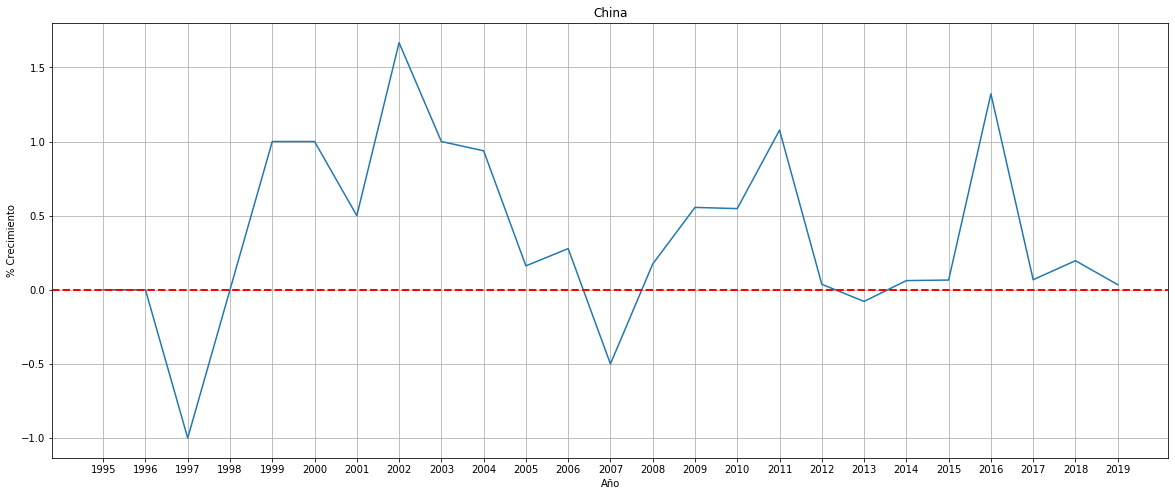

In [106]:
# Data for plotting
t = d2[country].index
s = d2[country].values

#figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='Año', ylabel='% Crecimiento',
       title=country)
ax.grid()

plt.axhline(y=0.0, linewidth=2, color='r', linestyle='--')
fig.set_size_inches(20,8)

fig.savefig("ds_"+country+".png", dpi=100)
plt.show()